## Hypothesis 4: "More testing leads to lower transmission later"

- H0: More testing does not affect the transmission rate
- H1: More testing increases the transmission rate
- H2: More testing decreases the transmission rate

### Introduction 

In summer, Texas experienced a dramatic increase in COVID-19 cases. Some counties were more affected than others.  Previously in this course, students noticed a few counties that were testing aggressively early on. Other counties did not accelerate testing until some time after the major increase. As a class, we were interested to see if the proactive (strong early testing) counties generally experienced a less severe rate of transmission later on. 

#### Analysis approach
- Relationship between early testing practices and rate of transmission (Rt)
- Skeptical of simple measures to extract Rt directly from raw data
- Instead, use total cases and total fatalities as the result of Rt
- The time series is split into early and later periods, so that we can compare early testing to later cases and fatalities
- The time split chosen by plotting the Texas average cases and finding where the curve swings up, indicating when Texas experienced major C19 outbreaks
- All stats are per-capita for a fairer comparison between counties
- Even then, makes little sense to compare, for example, Loving to Dallas --> counties grouped into 5 pop. classes
- Counties are also grouped using quantiles by their amount of early testing --> less (0 - 0.4), medium (0.4 - 0.6), and more (0.6 - 1.0). 


In [67]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import re
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

# Load data
!rm case_clean.csv* test_clean.csv* pop.csv* fatal_clean.csv*
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/case_clean.csv"
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/fatal_clean.csv"
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/test_clean.csv"
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/Population_density.csv" -O pop.csv
!rm counties* County.*
!wget https://opendata.arcgis.com/datasets/9b2eb7d232584572ad53bad41c76b04d_0.zip -O counties.zip
!unzip counties.zip

--2020-09-30 17:53:43--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/case_clean.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 264417 (258K) [text/plain]
Saving to: ‘case_clean.csv’

case_clean.csv      100%[===================>] 258.22K   242KB/s    in 1.1s    

2020-09-30 17:53:44 (242 KB/s) - ‘case_clean.csv’ saved [264417/264417]

--2020-09-30 17:53:44--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/fatal_clean.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 119083 (116K) [text/p

### Data 

**COVID-19 cumulative cases.**
The hypothesis asks what happens to the rate of transmission.
Here, uses cases as a surrogate for the transmission rate. 
There is an obvious relationship between the two; more cases suggest a higher transmission rate. Note that, while supposedly cumulative, the counts occasionally decrease.

- Source: DSHS, https://dshs.texas.gov/coronavirus/additionaldata.aspx 

**COVID-19 cumulative fatalities.**
The hypothesis asks what happens to the rate of transmission.
We also test using total fatalities to represent transmission rate.

**COVID-19 cumulative tests.**
The hypothesis considers how each county's testing impacts later COVID-19 transmission. Note that there are days with missing data; they have been filled with the mean of the days before and after.

- Source: DSHS, https://dshs.texas.gov/coronavirus/additionaldata.aspx 

**Texas county populations.** 
Large counties are extremely likely to experience a far greater number of cases than smaller one. The population size is used to compare cases and test _per capita_ and to group the counties into population size-based classes for a fairer comparison. 

- texascounties.net, http://www.texascounties.net/statistics/popdensity2010.htm

In [68]:
# Load data 
# Cumulative cases
dfCase = pd.read_csv("case_clean.csv", index_col = 0).astype("int")
dfCase_T = dfCase.T
dfCase_T = dfCase_T.cummax()
# Cumulative fatalities
dfFatal = pd.read_csv("fatal_clean.csv", index_col = 0).astype("int")
dfFatal_T = dfFatal.T
dfFatal_T = dfFatal_T.cummax()
# Cumulative tests
dfTest = pd.read_csv("test_clean.csv", index_col = 0)
dfTest.replace(0, np.nan, inplace = True)
s = dfTest.notna()
mask = s.shift(1, axis=1) & s.shift(-1, axis=1)
dfTest[:] = np.where(mask, dfTest.interpolate(axis=1), dfTest.bfill(axis=1).ffill(axis=1))
dfTest_T = dfTest.T
dfTest_T = dfTest_T.cummax()

# Population
dfPop = pd.read_csv("pop.csv", quotechar = '"', skipinitialspace = True)
dfPop = dfPop.replace(',','', regex=True)
dfPop["Population2010"] = dfPop["Population2010"].apply(pd.to_numeric,errors='coerce')
dfPop = dfPop.drop(dfPop.columns[0], axis = 1)
dfPop = dfPop.drop(dfPop.columns[1], axis = 1)
dfPop = dfPop.drop(dfPop.columns[2], axis = 1)
dfPop["Name"] = dfPop["Name"].str.lower()
dfPop.columns = ["name", "pop"]
dfPop.drop(dfPop.tail(1).index, inplace = True)
# dfPop["name"] = dfPop["name"].str.replace(' ', '_')

# Texas population
popTexas = dfPop["pop"].sum()

# Counties
counties = list(dfPop["name"])

### Determine date to split "early" and "later" time periods

The hypothesis has a notion of something happening "earlier" to affect something observed "later". A reasonable split is before the massive Texas-wide increase in cases and after. 

The following block visualizes the Texas cumulative tests and cases so that a split date can be selected. The curves are smoothed with a 7-day average. Once chosen, a vertical bar is added to split the data visually. 


Separatation date: June 15


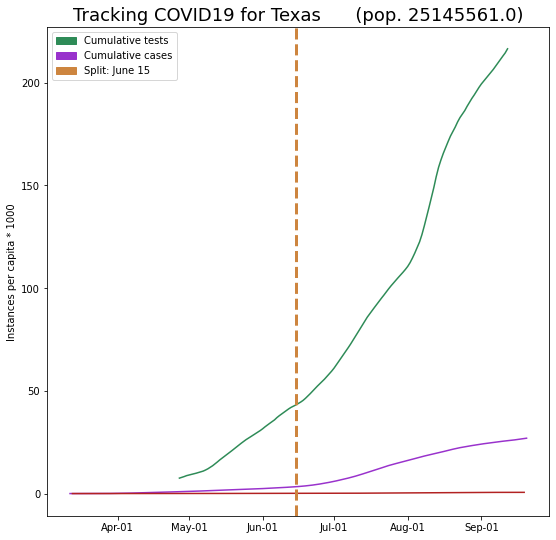

In [69]:
CUT = 100 # Where to split the data

pattern = re.compile('[0-9]+-[0-9]+', re.IGNORECASE)
datesCase = [datetime.strptime(pattern.findall(sub)[0], '%m-%d') for sub in dfCase.keys()]
datesFatal = [datetime.strptime(pattern.findall(sub)[0], '%m-%d') for sub in dfFatal.keys()]
datesTest = [datetime.strptime(pattern.findall(sub)[0], '%m-%d') for sub in dfTest.keys()]

fig, ax = plt.subplots(1, 1, figsize = (9, 9))
ax.title.set_text("Tracking COVID19 for Texas      (pop. {p})".format(p = popTexas))
ax.title.set_fontsize(18)
ax.plot(datesCase, dfCase_T["total"].rolling(window = 7).mean() / popTexas * 1000, color = "darkorchid")
ax.plot(datesFatal, dfFatal_T["total"].rolling(window = 7).mean() / popTexas * 1000, color = "firebrick")
ax.plot(datesTest, dfTest_T["total"].rolling(window = 7).mean() / popTexas * 1000, color = "seagreen")

ax.axvline(datesCase[CUT], 0, 1, c = "peru", label = datesCase[CUT].strftime("Split: %B %d"), linewidth = 3, linestyle = "dashed")

casePatch = mpatches.Patch(color = "darkorchid", label = "Cumulative cases", linestyle = "solid")
testPatch = mpatches.Patch(color = "seagreen", label = "Cumulative tests", linestyle = "solid")
splitPatch = mpatches.Patch(color = "peru", label = datesCase[CUT].strftime("Split: %B %d"))

ax.legend(loc = "upper left", handles = [testPatch, casePatch, splitPatch])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))

ax.set_ylabel("Instances per capita * 1000")

print(datesCase[CUT].strftime("Separatation date: %B %d"))

### Calculate _per-capita_ cases, fatalities, and tests

For a fairer comparison between the counties of widely-different populations. 

In [70]:
# Calculate per-capita data
dfCasePC = dfCase.copy()
dfCasePC_T = dfCasePC.T
dfCasePC_T = dfCasePC_T.cummax()
dfFatalPC = dfFatal.copy()
dfFatalPC_T = dfFatalPC.T
dfFatalPC_T = dfFatalPC_T.cummax()
dfTestPC = dfTest.copy()
dfTestPC_T = dfTestPC.T
dfTestPC_T = dfTestPC_T.cummax()

for county in counties:
  # Get county population
  pop = dfPop[dfPop["name"] == county]["pop"]
  # Calc cases per capita 
  dfCasePC_T[county] = dfCasePC_T[county] / float(pop) * 1000
  # Calc fatalities per capita
  dfFatalPC_T[county] = dfFatalPC_T[county] / float(pop) * 100000
  # Calc tests per capita
  dfTestPC_T[county] = dfTestPC_T[county] / float(pop) * 1000


### Group counties by population

Even using _per-capita_ values, it does not seem reasonable to compare the spread of a metropolis like Dallas to Loving county with population est. 134. Instead, the counties are grouped by population and comparisons are within. 

In [71]:
# Group counties into population classes
classLabels = ['A', 'B', 'C', 'D', 'E']
ntiles = [0, .2, .4, .6, .8, 1]
bins, binEdges = pd.qcut(dfPop['pop'], q = ntiles, labels = classLabels, retbins = True)
dfPop["class"] = bins
classes = pd.DataFrame(zip(binEdges, classLabels), columns = ['Threshold', 'Tier'])

dfCounties = dfPop.copy()

print(dfTestPC_T["anderson"].sum())

dfCounties["total_tests"] = [dfTestPC_T[c][-1] for c in counties]
dfCounties["before_tests"] = [dfTestPC_T[0:CUT][c][-1] for c in counties]
dfCounties["total_cases"] = [dfCasePC_T[c][-1] for c in counties]
dfCounties["total_fatalities"] = [dfFatalPC_T[c][-1] for c in counties]
print(dfCounties)

print(classes)
print("\n")
print(dfCounties)

class2county = {}
for c in classLabels:
  class2county[c] = dfCounties.loc[dfCounties["class"] == c]
  

27094.53795887646
         name        pop class  ...  before_tests  total_cases  total_fatalities
0      dallas  2368139.0     E  ...    140.269638    32.564811         45.816567
1      harris  4092459.0     E  ...    122.789746    30.119789         61.185708
2     tarrant  1809034.0     E  ...    101.720034    23.970804         38.307738
3       bexar  1714773.0     E  ...     98.215915    24.193290         72.662679
4      travis  1024266.0     E  ...    111.336313    27.764272         39.345248
..        ...        ...   ...  ...           ...          ...               ...
249  mcmullen      707.0     A  ...     59.405941    29.702970          0.000000
250   terrell      984.0     A  ...      6.097561     3.048780          0.000000
251      king      286.0     A  ...     17.482517     0.000000          0.000000
252    kenedy      416.0     A  ...     31.250000    19.230769        240.384615
253    loving       82.0     A  ...     24.390244     0.000000          0.000000

[254 rows

### Split each groups again based on early testing

The total tests before the split date are used to divide the counties. The hypothesis test will compare, within each population class, the post-split date cases between low and high-testing counties.

Quantiles are used for the following groups:

1. 0 - 0.45: less testing
2. 0.45 - 0.55: middle testing
3. 0.55 - 1.0: more testing

The purpose of the middle group is so that borderline cases can be removed from the comparison. Along the split, there may be counties whose testing is barely distinguishable. It is not desirable for these to influence the test when their separation is somewhat arbitrary. 

In [72]:
# Further group each population class into "higher"/"lower" testing classes
testClassLabels = ["less", "middle", "more"]
binary = [0, 0.4, 0.6, 1]

for c in classLabels:
  bins, binEdges = pd.qcut(class2county[c]['before_tests'], q = binary, labels = testClassLabels, retbins = True)
  class2county[c]["test_class"] = bins

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

### Testing and cases for each population class

The following block plots the daily tests and cases for each population class. Each population class is further divided by less and more early testing. The early testing (before the split) is shown, as well as the full daily cases. The purpose is to check, visually, what we expect of the result of the hypothesis test. 

Each row is one population class, ordered smallest to largest populations.
The left column is for counties in that class with less early testing, and the right column for those with more. 


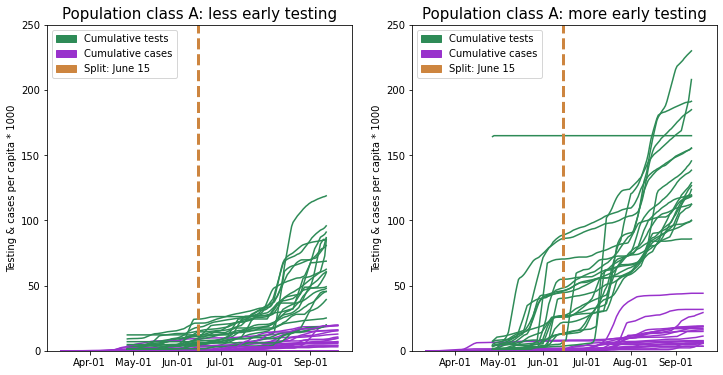

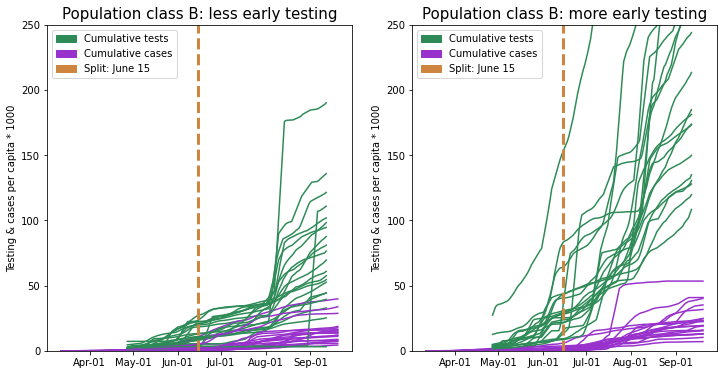

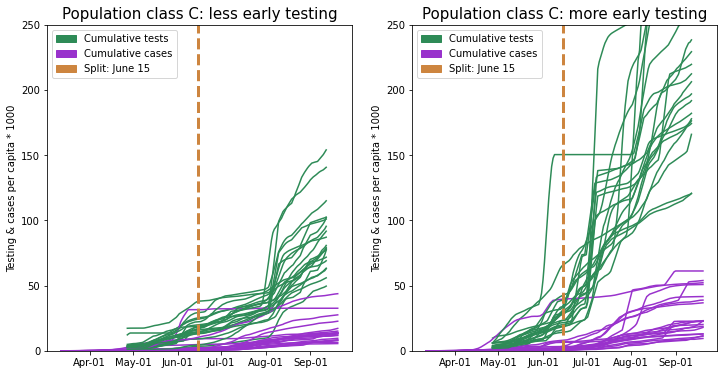

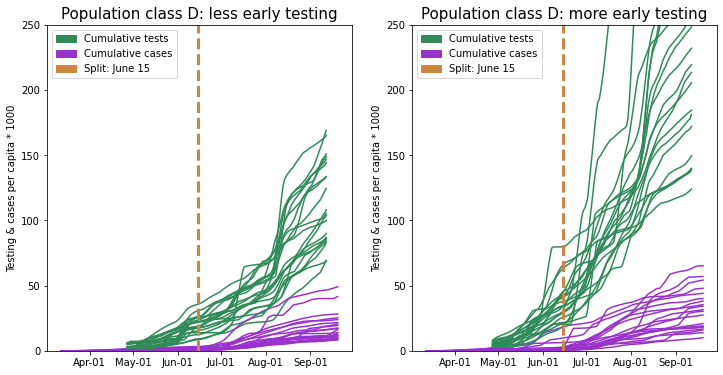

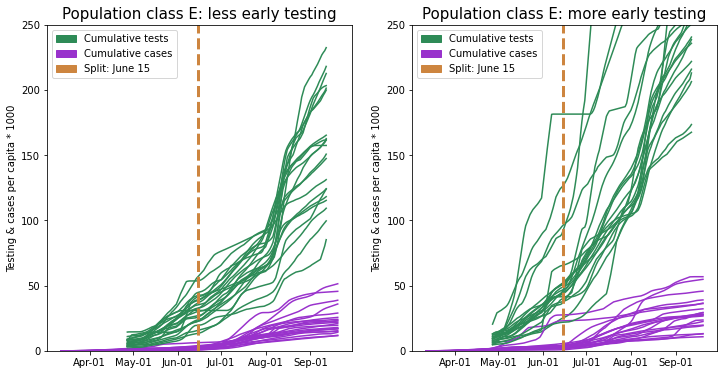

In [73]:
# Visualize groups
for pop_grp in classLabels:
  df = class2county[pop_grp]
 
  fig, axs = plt.subplots(1, 2, figsize = (12, 6))
  axs[0].title.set_text("Population class {c}: less early testing".format(c = pop_grp))
  axs[0].title.set_fontsize(15)
 
  axs[1].title.set_text("Population class {c}: more early testing".format(c = pop_grp))
  axs[1].title.set_fontsize(15)
 
  for county in list(df.loc[df["test_class"] == "less"]["name"]):
    axs[0].plot(datesCase, dfCasePC_T[county].rolling(window = 7).mean(), color = "darkorchid")
    axs[0].plot(datesTest, dfTestPC_T[county].rolling(window = 7).mean(), color = "seagreen")
 
  for county in list(df.loc[df["test_class"] == "more"]["name"]):
    axs[1].plot(datesCase, dfCasePC_T[county].rolling(window = 7).mean(), color = "darkorchid")
    axs[1].plot(datesTest, dfTestPC_T[county].rolling(window = 7).mean(), color = "seagreen")

  casePatch = mpatches.Patch(color = "darkorchid", label = "Cumulative cases", linestyle = "solid")
  testPatch = mpatches.Patch(color = "seagreen", label = "Cumulative tests", linestyle = "solid")
  splitPatch = mpatches.Patch(color = "peru", label = datesCase[CUT].strftime("Split: %B %d"))

  axs[0].axvline(datesCase[CUT], 0, 1, c = "peru", label = datesCase[CUT].strftime("Split: %B %d"), linewidth = 3, linestyle = "dashed")
  axs[0].legend(loc = "upper left", handles = [testPatch, casePatch, splitPatch])
  axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
  axs[0].set_ylim([0, 250])
  axs[0].set_ylabel("Testing & cases per capita * 1000")
 
  axs[1].axvline(datesCase[CUT], 0, 1, c = "peru", label = datesCase[CUT].strftime("Split: %B %d"), linewidth = 3, linestyle = "dashed")
  axs[1].legend(loc = "upper left", handles = [testPatch, casePatch, splitPatch])
  axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
  axs[1].set_ylim([0, 250])
  axs[1].set_ylabel("Testing & cases per capita * 1000")




### Testing and fatalities for each population class

The following block plots the daily tests and fatalities for each population class. Each population class is further divided by less and more early testing. The early testing (before the split) is shown, as well as the full daily cases. The purpose is to check, visually, what we expect of the result of the hypothesis test. 

Each row is one population class, ordered smallest to largest populations.
The left column is for counties in that class with less early testing, and the right column for those with more. 

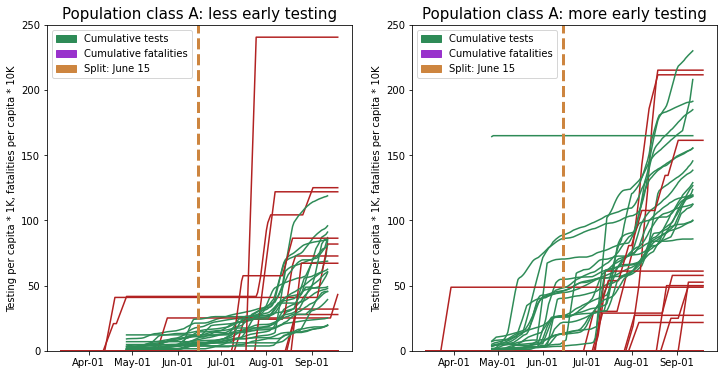

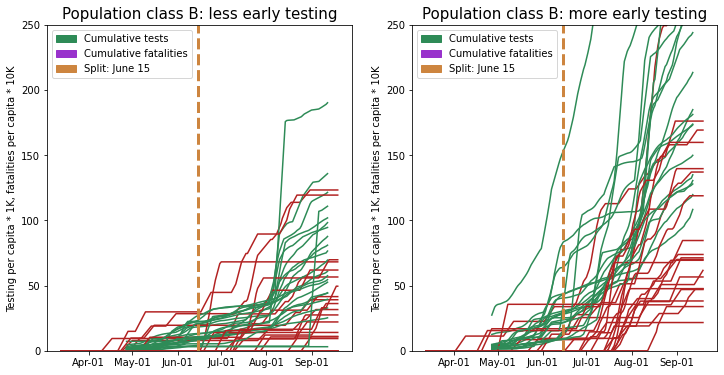

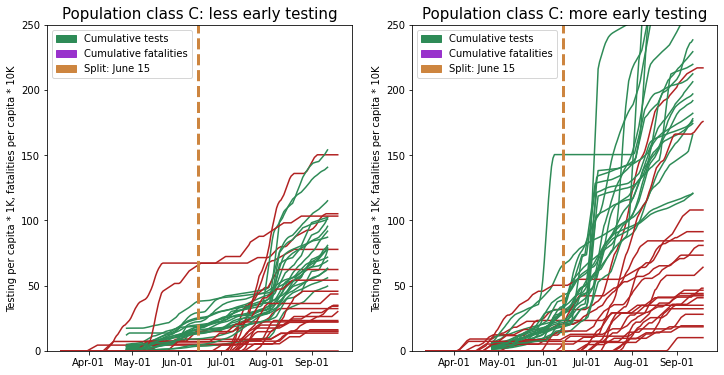

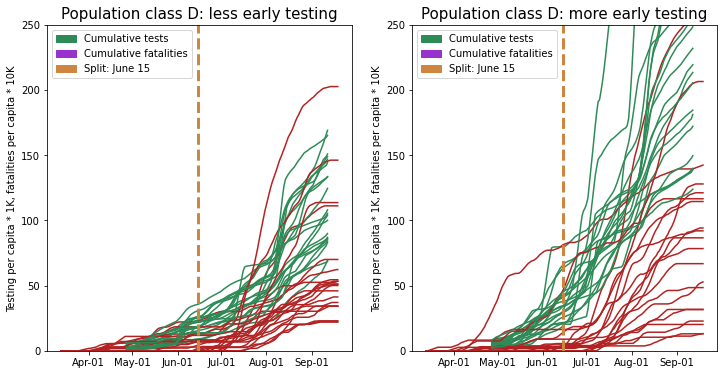

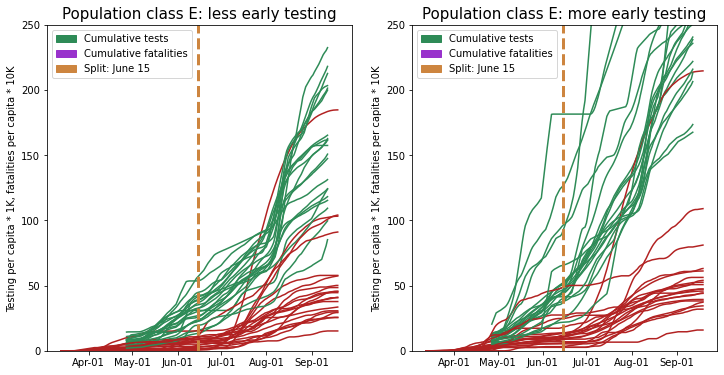

In [74]:
# Visualize groups
for pop_grp in classLabels:
  df = class2county[pop_grp]
 
  fig, axs = plt.subplots(1, 2, figsize = (12, 6))
  axs[0].title.set_text("Population class {c}: less early testing".format(c = pop_grp))
  axs[0].title.set_fontsize(15)
 
  axs[1].title.set_text("Population class {c}: more early testing".format(c = pop_grp))
  axs[1].title.set_fontsize(15)
 
  for county in list(df.loc[df["test_class"] == "less"]["name"]):
    axs[0].plot(datesFatal, dfFatalPC_T[county].rolling(window = 7).mean(), color = "firebrick")
    axs[0].plot(datesTest, dfTestPC_T[county].rolling(window = 7).mean(), color = "seagreen")
 
  for county in list(df.loc[df["test_class"] == "more"]["name"]):
    axs[1].plot(datesFatal, dfFatalPC_T[county].rolling(window = 7).mean(), color = "firebrick")
    axs[1].plot(datesTest, dfTestPC_T[county].rolling(window = 7).mean(), color = "seagreen")

  fatalPatch = mpatches.Patch(color = "darkorchid", label = "Cumulative fatalities", linestyle = "solid")
  testPatch = mpatches.Patch(color = "seagreen", label = "Cumulative tests", linestyle = "solid")
  splitPatch = mpatches.Patch(color = "peru", label = datesFatal[CUT].strftime("Split: %B %d"))

  axs[0].axvline(datesFatal[CUT], 0, 1, c = "peru", label = datesFatal[CUT].strftime("Split: %B %d"), linewidth = 3, linestyle = "dashed")
  axs[0].legend(loc = "upper left", handles = [testPatch, fatalPatch, splitPatch])
  axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
  axs[0].set_ylim([0, 250])
  axs[0].set_ylabel("Testing per capita * 1K, fatalities per capita * 10K")
 
  axs[1].axvline(datesFatal[CUT], 0, 1, c = "peru", label = datesFatal[CUT].strftime("Split: %B %d"), linewidth = 3, linestyle = "dashed")
  axs[1].legend(loc = "upper left", handles = [testPatch, fatalPatch, splitPatch])
  axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
  axs[1].set_ylim([0, 250])
  axs[1].set_ylabel("Testing per capita * 1K, fatalities per capita * 10K")


### Perform T-test

Each test is performed between the _less_ and _more_ early testing counties, within each population class. So, there is a P-value for each population class. 


In [75]:
# T-test
for c in classLabels:
  df = class2county[c]
 
  # Cases test
    # Sample 1
  casesLessTesting = df.loc[df["test_class"] == "less"]["total_cases"]
    # Sample 2
  casesMoreTesting = df.loc[df["test_class"] == "more"]["total_cases"]
    # Test
  ttestCase, pvalCase = ttest_ind(casesLessTesting, casesMoreTesting)

  # Fatalities test
    # Sample 1
  fatalsLessTesting = df.loc[df["test_class"] == "less"]["total_fatalities"]
    # Sample 2
  fatalsMoreTesting = df.loc[df["test_class"] == "more"]["total_fatalities"]
    # Test
  ttestFatal, pvalFatal = ttest_ind(fatalsLessTesting, fatalsMoreTesting)
 

  print("Population class {c}:".format(c = c))
  print("\tCases, P = {p}".format(p = pvalCase))
  print("\tFatalities, P = {p}".format(p = pvalFatal))




Population class A:
	Cases, P = 0.14604847522388184
	Fatalities, P = 0.8181608067109545
Population class B:
	Cases, P = 0.01930990470140422
	Fatalities, P = 0.0012676136621821656
Population class C:
	Cases, P = 0.004057845675893498
	Fatalities, P = 0.17479416511516477
Population class D:
	Cases, P = 0.0033186786561461208
	Fatalities, P = 0.16927663417505245
Population class E:
	Cases, P = 0.11866201172381263
	Fatalities, P = 0.7450929476581702


### Map of counties, colored by their population class

- Shapefile: https://gis-txdot.opendata.arcgis.com/datasets/texas-county-boundaries

In [76]:
# Install Basemap package, if not installed
try:
  m = Basemap()
except:
  !apt-get install libgeos-3.5.0
  !apt-get install libgeos-dev
  !pip install -U git+https://github.com/matplotlib/basemap.git

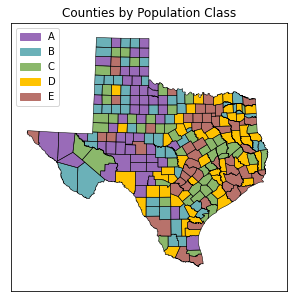

In [77]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

colors = [
          (184 / 255, 114 / 255, 107 / 255), 
          (255 / 255, 195 / 255, 0 / 255),
          (139 / 255, 184 / 255, 107 / 255),
          (107 / 255, 177 / 255, 184 / 255),
          (153 / 255, 107 / 255, 184 / 255),

]

class2idx = {
    "A" : 4,
    "B" : 3,
    "C" : 2, 
    "D" : 1,
    "E" : 0,
}

# Lat, lon bounds
lllon = -107
urlon = -92
lllat = 24.5
urlat = 37
# Centerpoint
centerlon = float(lllon + urlon) / 2.0
centerlat = float(lllat + urlat) / 2.0

# Init basemap with projection, bounds
m = Basemap(resolution = 'i',
            llcrnrlon = lllon, urcrnrlon = urlon,
            lon_0 = centerlon,
            llcrnrlat = lllat, urcrnrlat = urlat,
            lat_0 = centerlat,
            projection='tmerc')

# Read county boundaries
shp_info = m.readshapefile('County', 'counties', drawbounds = True)

plt.title('Counties by Population Class')
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 0)

ax = plt.gca()
for i, county in enumerate(m.counties_info):
  name = county["CNTY_NM"]
  if name == "De Witt":
    name = "dewitt"
  try:
    label = dfCounties[dfCounties["name"] == name.lower()]["class"].values[0]
  except:
    print(name)
  idx = class2idx[label]
  color = colors[idx]

  countyseg = m.counties[i]
  poly = Polygon(countyseg, facecolor = color)  # edgecolor="white"
  ax.add_patch(poly)

patches = [
            mpatches.Patch(color = colors[4], label = "A", linestyle = "solid"),
            mpatches.Patch(color = colors[3], label = "B", linestyle = "solid"),
            mpatches.Patch(color = colors[2], label = "C", linestyle = "solid"),
            mpatches.Patch(color = colors[1], label = "D", linestyle = "solid"),
            mpatches.Patch(color = colors[0], label = "E", linestyle = "solid"),
]

ax.legend(loc = "upper left", handles = patches)



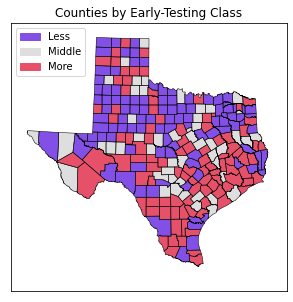

In [78]:
colors = [
          (130 / 255,  80 / 255, 231 / 255), 
          (222 / 255, 222 / 255, 222 / 255),
          (231 / 255,  80 / 255, 105 / 255),
]

class2idx = {
    "less"   : 0,
    "middle" : 1,
    "more"   : 2, 
}

# Lat, lon bounds
lllon = -107
urlon = -92
lllat = 24.5
urlat = 37
# Centerpoint
centerlon = float(lllon + urlon) / 2.0
centerlat = float(lllat + urlat) / 2.0

# Init basemap with projection, bounds
m = Basemap(resolution = 'i',
            llcrnrlon = lllon, urcrnrlon = urlon,
            lon_0 = centerlon,
            llcrnrlat = lllat, urcrnrlat = urlat,
            lat_0 = centerlat,
            projection='tmerc')

# Read county boundaries
shp_info = m.readshapefile('County', 'counties', drawbounds = True)

plt.title('Counties by Early-Testing Class')
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 0)

ax = plt.gca()
for i, county in enumerate(m.counties_info):
  name = county["CNTY_NM"]
  if name == "De Witt":
    name = "dewitt"
  try:
    label = dfCounties[dfCounties["name"] == name.lower()]["class"].values[0]
  except:
    print(name)

  df = class2county[label]

  test_class = df[df["name"] == name.lower()]["test_class"].values[0]

  idx = class2idx[test_class]
  color = colors[idx]

  countyseg = m.counties[i]
  poly = Polygon(countyseg, facecolor = color)  # edgecolor="white"
  ax.add_patch(poly)

patches = [
            mpatches.Patch(color = colors[0], label = "Less", linestyle = "solid"),
            mpatches.Patch(color = colors[1], label = "Middle", linestyle = "solid"),
            mpatches.Patch(color = colors[2], label = "More", linestyle = "solid"),
]

ax.legend(loc = "upper left", handles = patches)



### Results
- We students came up with the hypothesis based on initial observations where Nueces was slow to ramp up testing and experienced a harsh C19 outbreak.
- Perhaps more early testing represented counties with a proactive approach to the virus, and would have less C19 impact.
- The T-tests do not really show this.
- Only some tests show a significant p-value
- Even then, it is usually for the opposite case: more testing --> more cases & fatalities!
- Which makes sense since more testing reveals more casee

Fail to conclusively reject the null (some tests not significant), but many tests show significance toward the alternative: more early testing suggests greater known spread